# Libraries

In [1]:
from  google.colab  import  drive 
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import scipy
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics.pairwise as pw
from sklearn.metrics.pairwise import pairwise_distances
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import random
from scipy import sparse
from scipy.stats import pearsonr
import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords
import torch
from torchtext import data
from torchtext import datasets

# Pre-Processing

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Airlines Reviews/reviews_with_emotions_full.csv')
del df['AirlineId']
del df['Unnamed: 0']
df = df.reindex(columns=['UserId', 'Name', 'Review', 'Rating', 'Emotion'])
df.head()

,UserId,Name,Review,Rating,Emotion
0,1,aegean,Forgot my baggage,1,neutral
1,2,aegean,Late or cancelled,1,confusion
2,3,aegean,Worst experience ever! AVOID AEGEAN!,1,fear
3,4,aegean,A great airline,4,admiration
4,5,aegean,"Accommodating, Lovely Airline",5,admiration


Για να ταξινομήσω τις θετικές ή τις αρνητικές κριτικές, θα συγκεντρώσω τα ratings 4 και 5 που βαθμολογήθηκαν μαζί ως θετικές και θα τις κωδικοποιήσω ως 2. Θα κωδικοποιήσω τη βαθμολογία 3 ως 0 και τη βαθμολογία 1 και 2 ως 1.

In [6]:
def calc_sentiment_with_neutral(overall):
    if overall == 5 or overall == 4:
        return 2
    elif overall == 1 or overall==2 : 
        return 0
    else:
        return 1

In [7]:
df['sentiment'] = df['Rating'].apply(calc_sentiment_with_neutral)

In [8]:
df.groupby(['sentiment','Rating']).count()

UserId  Name  Review  Emotion
sentiment Rating                               
0         1         4948  4948    4948     4948
          2          795   795     795      795
1         3          832   832     832      832
2         4         1598  1598    1598     1598
          5         3238  3238    3238     3238

In [9]:
df['sentiment'].value_counts()

0    5743
2    4836
1     832
Name: sentiment, dtype: int64

In [10]:
df['Review']=df['Review'].str.lower()

In [11]:
df['Review']

0                                        forgot my baggage
1                                        late or cancelled
2                     worst experience ever! avoid aegean!
3                                          a great airline
4                            accommodating, lovely airline
                               ...                        
11406    an airline that cares about your comfort, not ...
11407                                          pure luxury
11408    comfy economy seats, but lack of air conditioning
11409                                           good value
11410                                    true friendly sky
Name: Review, Length: 11411, dtype: object

In [12]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def remove_punctuation(text):
    #η συνάρτηση χωρίζει τις λέξεις σε γράμματα, αφαιρεί σημεία στίξης και συγκεντρώνει ξανά γράμματα ως λέξεις
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc

In [14]:
df['Review_Clean'] = df['Review'].apply(lambda x: remove_punctuation(x))
df.head()

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage
1,2,aegean,late or cancelled,1,confusion,0,late or cancelled
2,3,aegean,worst experience ever! avoid aegean!,1,fear,0,worst experience ever avoid aegean
3,4,aegean,a great airline,4,admiration,2,a great airline
4,5,aegean,"accommodating, lovely airline",5,admiration,2,accommodating lovely airline


In [15]:
df_pos = df.loc[df['sentiment']==2] # θετικά reviews dataframe
df_neg = df.loc[df['sentiment']==0] # αρνητικά reviews dataframe
df_notr = df.loc[df['sentiment']==1] # neutral reviews dataframe

In [16]:
stop_words = set(STOPWORDS)

In [17]:
wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 500, max_font_size = 100, random_state = 42, width=800, height=400)

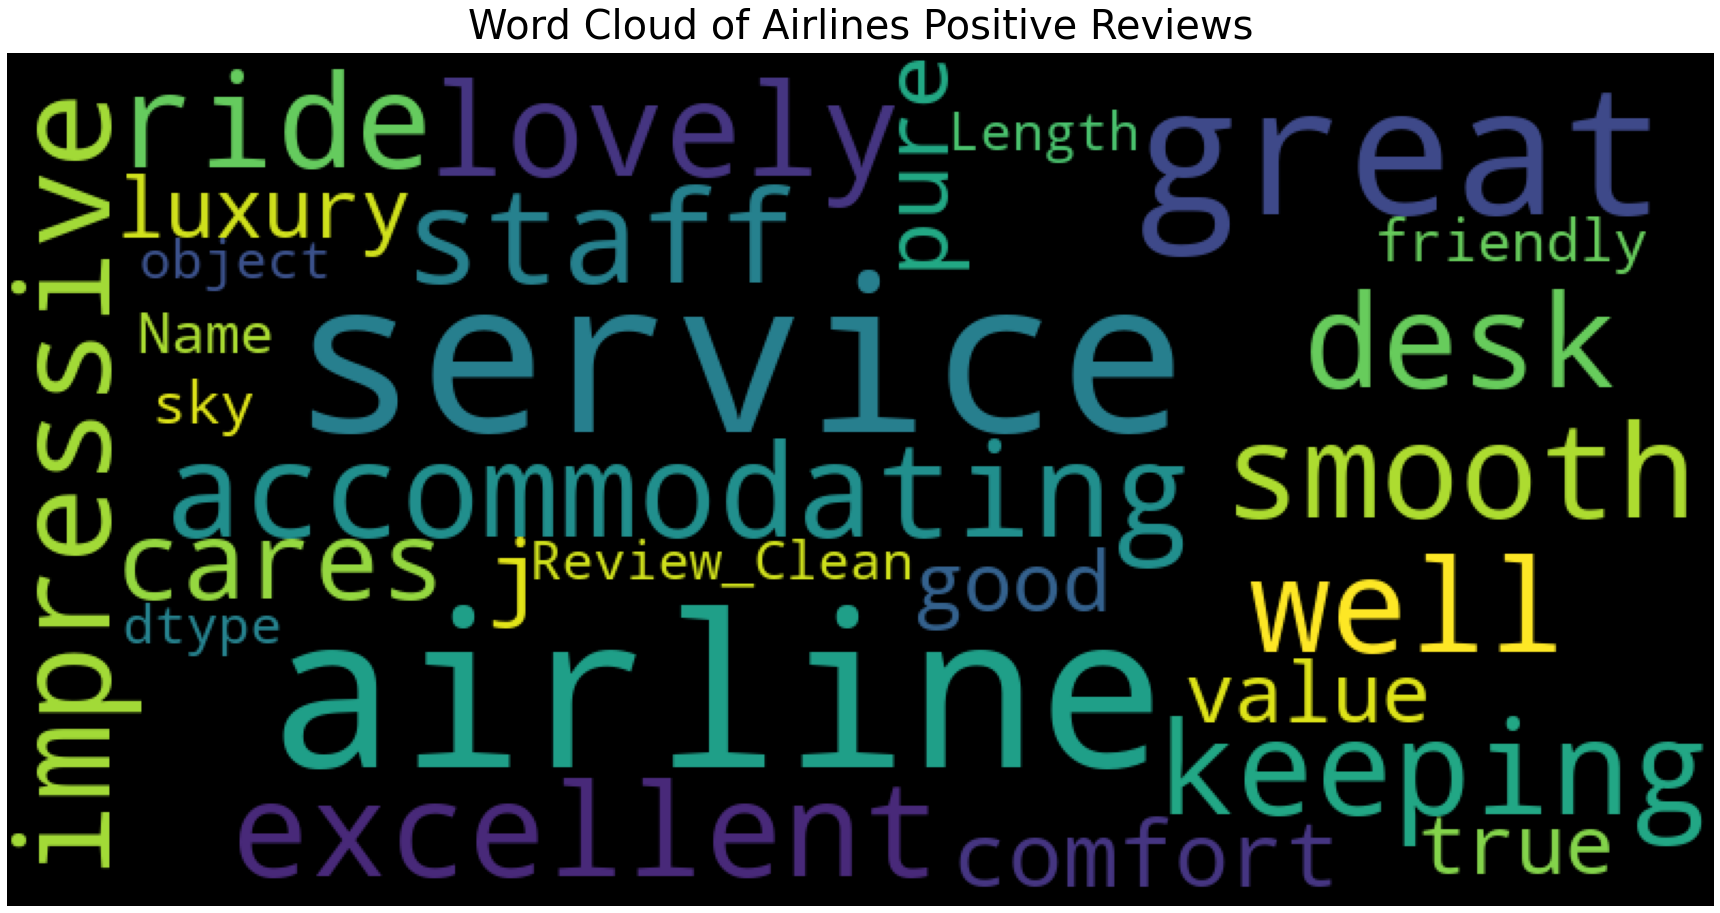

In [19]:
wordcloud.generate(str(df_pos['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Airlines Positive Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

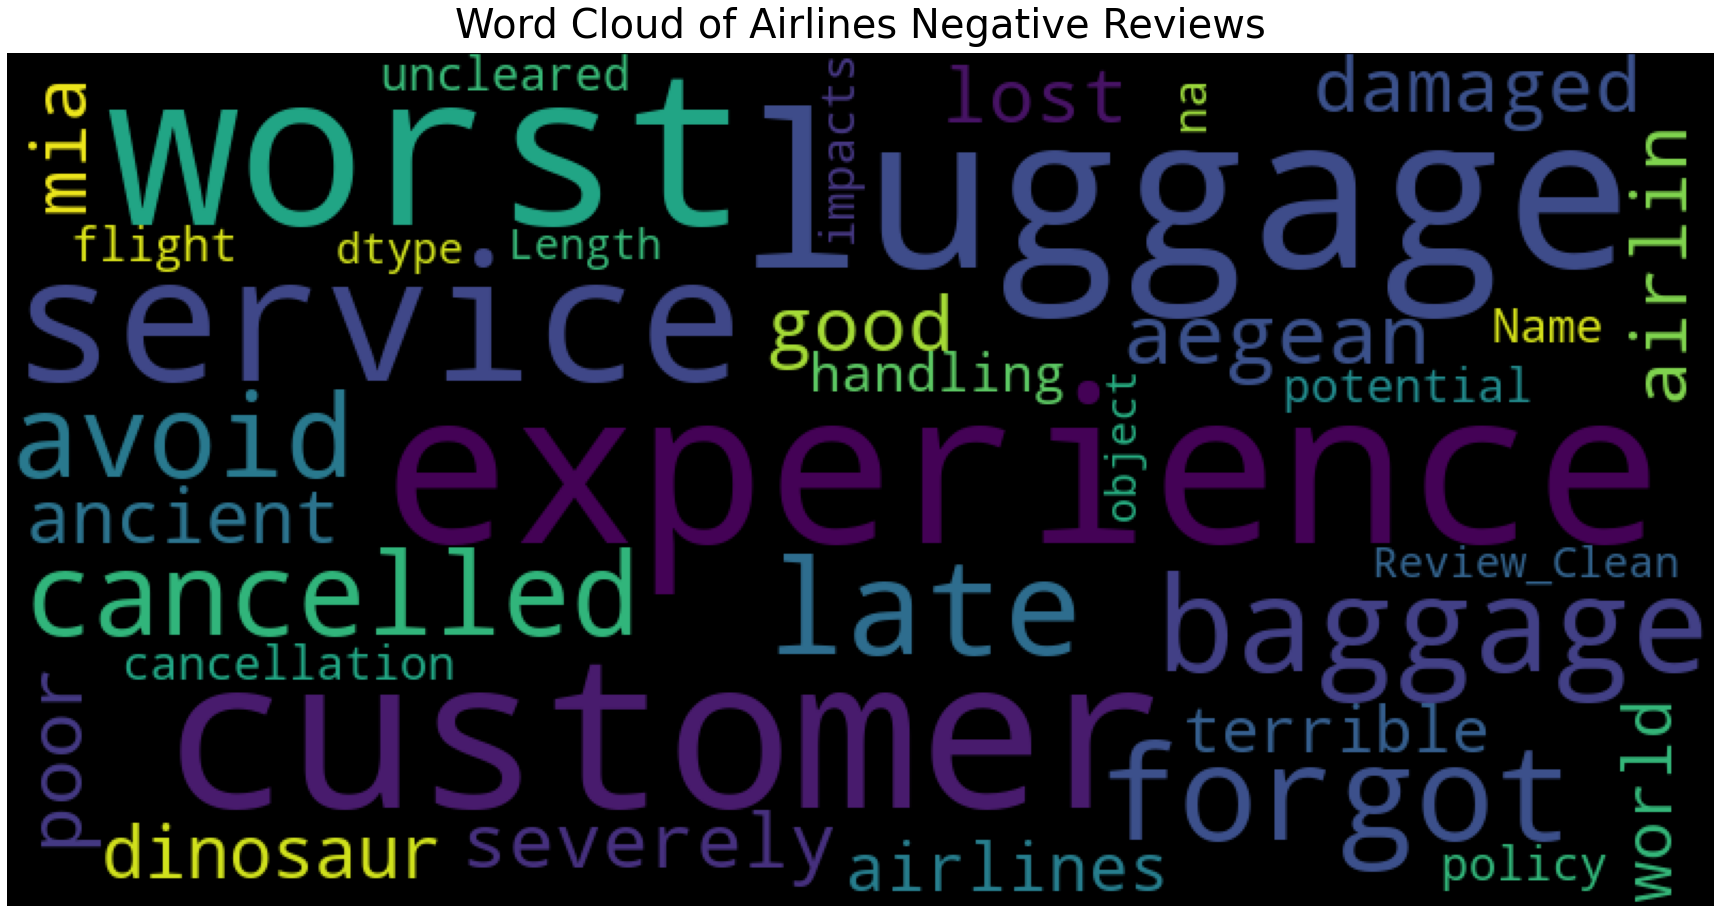

In [20]:
wordcloud.generate(str(df_neg['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Airlines Negative Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

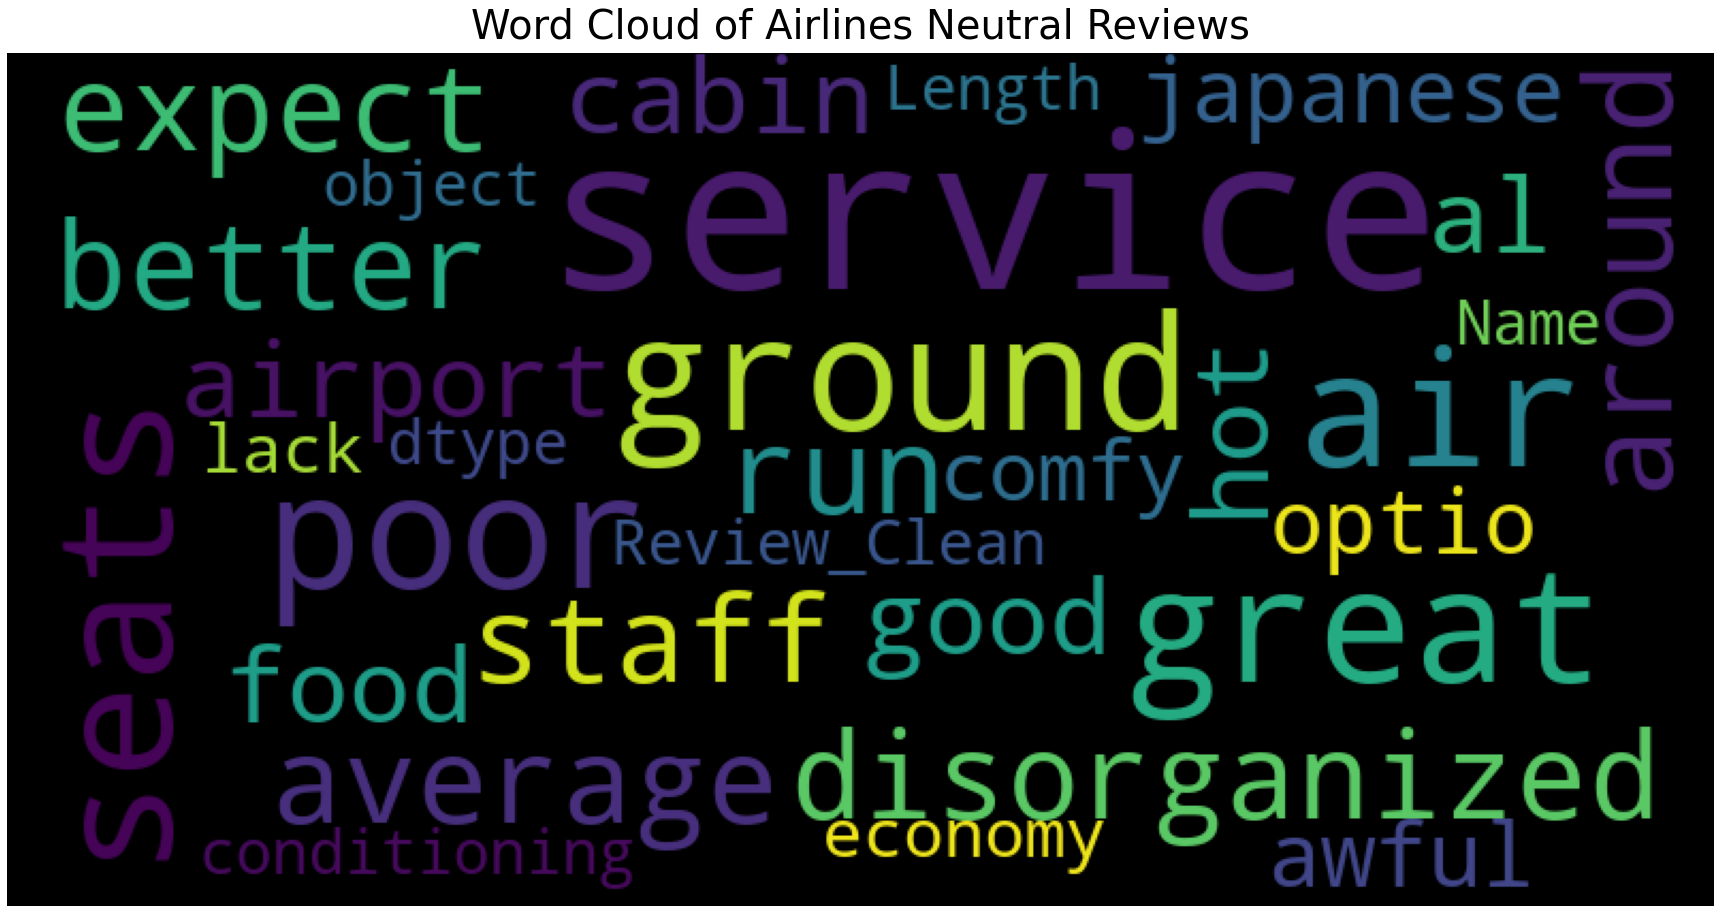

In [21]:
wordcloud.generate(str(df_notr['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Airlines Neutral Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

Τα wordclouds δίνουν μια γενική ιδέα για το τι είναι κείμενο, αλλά χρειάζονται πιο χαρακτηριστικές λέξεις επειδή όλες οι λέξεις δεν βρίσκονται στο ίδιο κείμενο σε αυτά τα δεδομένα.

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
def word_count(reviews):
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num

25 πιο κοινές λέξεις σε θετικές κριτικές

In [25]:
word_frequency=word_count(df_pos['Review_Clean'])

In [26]:
df_pos_count = pd.DataFrame(columns=['word', 'count'])
df_pos_count['word'] = word_frequency.keys()
df_pos_count['count'] = list(word_frequency.values())
df_pos_count=df_pos_count.sort_values(by=['count'], ascending=False)
df_pos_count=df_pos_count.reset_index(drop=True)

In [27]:
stop_words = set(STOPWORDS)

In [28]:
stop = set(stopwords.words("english"))

Θα δημιουργήσω νέα στήλη ως word_without_stop και θα κάνουμε drop τη σειρά εάν περιέχει ενδιάμεσες λέξεις.

In [29]:
df_pos_count['word_without_stop'] = df_pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [30]:
df_pos_without_stop = df_pos_count.dropna(subset=['word_without_stop'])

In [31]:
df_top_25_pos = df_pos_count.loc[df_pos_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


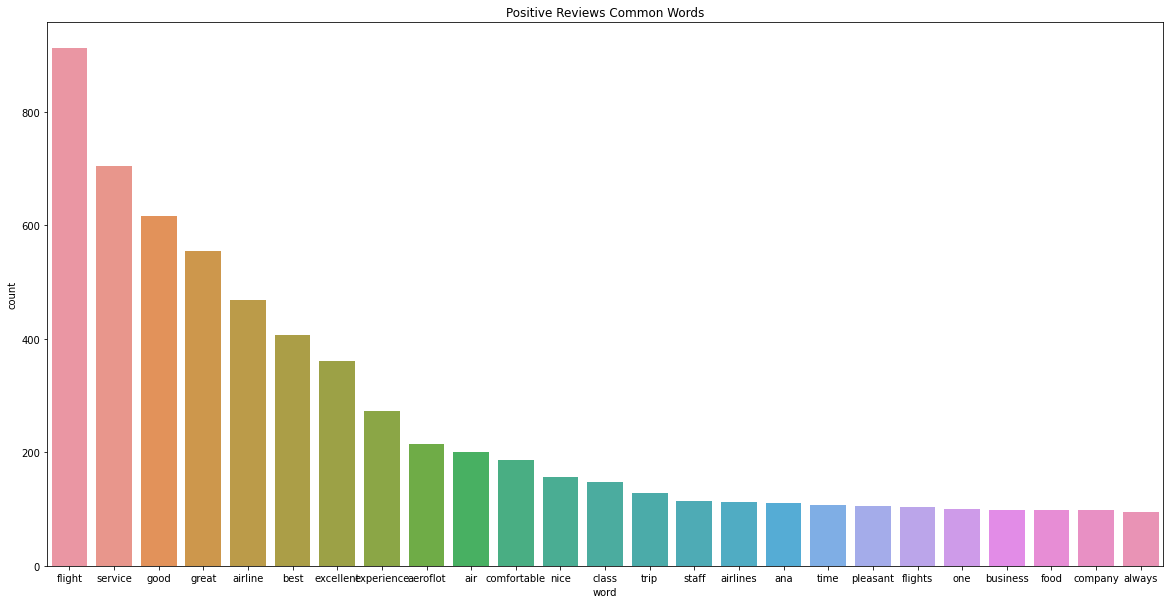

In [32]:
plt.figure(figsize=(20,10))
plt.title('Positive Reviews Common Words')
sns.barplot("word","count", data=df_top_25_pos)

25 πιο κοινές λέξεις σε αρνητικές κριτικές

In [33]:
word_frequency_neg=word_count(df_neg['Review_Clean'])

In [34]:
df_neg_count = pd.DataFrame(columns=['word', 'count'])
df_neg_count['word'] = word_frequency_neg.keys()
df_neg_count['count'] = list(word_frequency_neg.values())
df_neg_count=df_neg_count.sort_values(by=['count'], ascending=False)
df_neg_count=df_neg_count.reset_index(drop=True)

In [35]:
df_neg_count['word_without_stop'] = df_neg_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [36]:
df_neg_without_stop = df_neg_count.dropna(subset=['word_without_stop'])

In [37]:
df_top_25_neg = df_neg_count.loc[df_neg_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


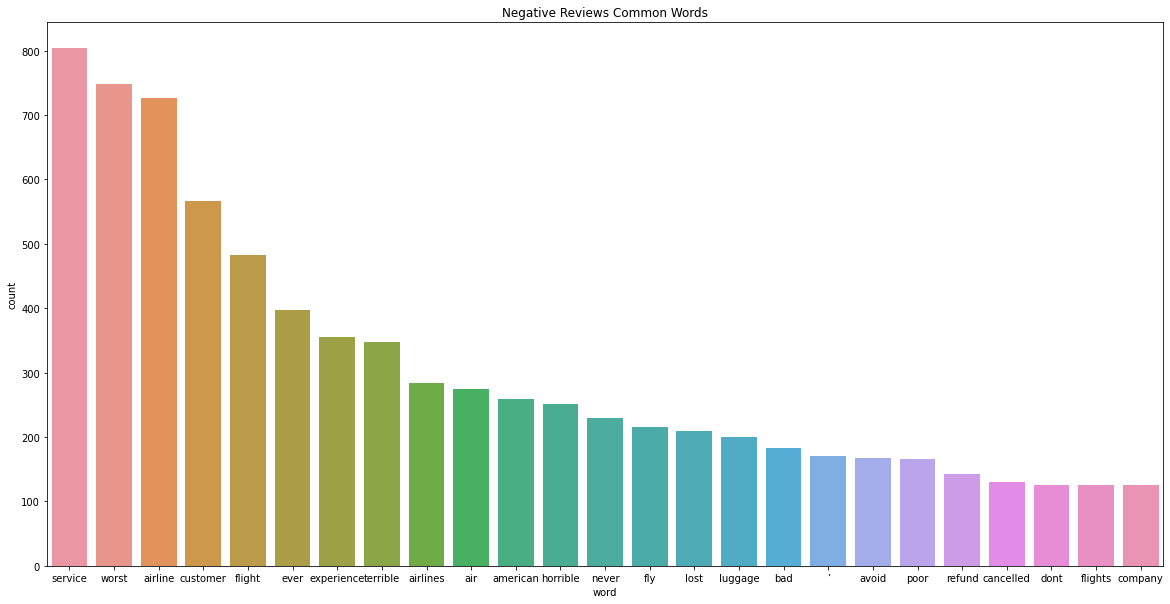

In [38]:
plt.figure(figsize=(20,10))
plt.title('Negative Reviews Common Words')
sns.barplot("word","count", data=df_top_25_neg)

25 πιο κοινές λέξεις σε neutral κριτικές

In [39]:
word_frequency_notr = word_count(df_notr['Review_Clean'])

In [40]:
df_nt_count = pd.DataFrame(columns=['word', 'count'])
df_nt_count['word'] = word_frequency_notr.keys()
df_nt_count['count'] = list(word_frequency_notr.values())
df_nt_count=df_nt_count.sort_values(by=['count'], ascending=False)
df_nt_count=df_nt_count.reset_index(drop=True)

In [41]:
df_nt_count['word_without_stop'] = df_nt_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [42]:
df_nt_without_stop = df_nt_count.dropna(subset=['word_without_stop'])

In [43]:
df_top_25_nt = df_nt_count.loc[df_nt_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


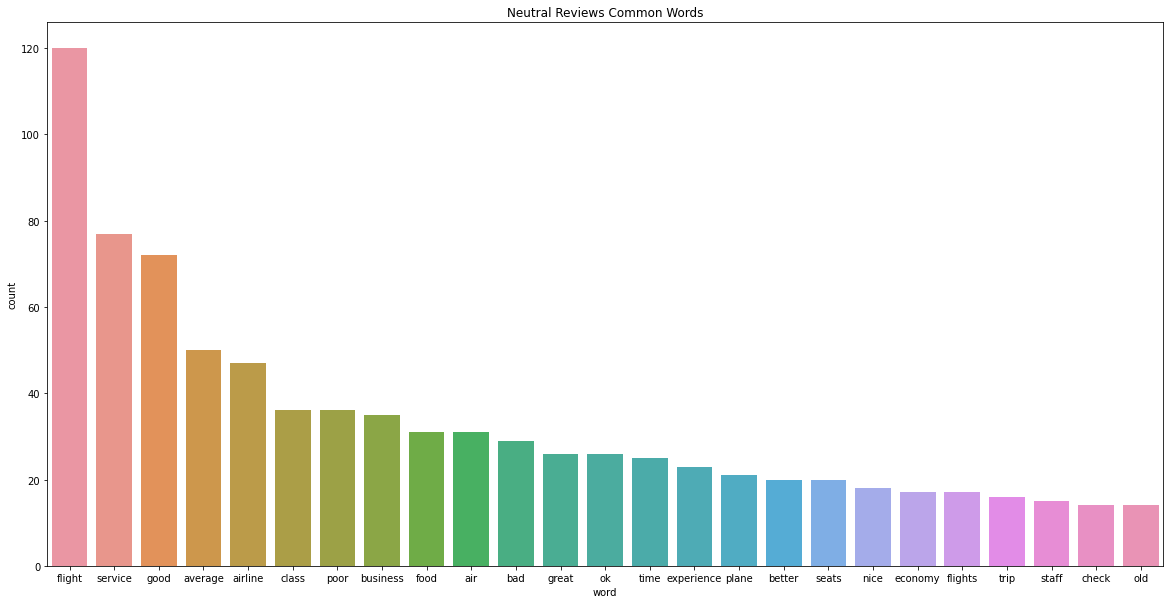

In [44]:
plt.figure(figsize=(20,10))
plt.title('Neutral Reviews Common Words')
sns.barplot("word","count", data=df_top_25_nt)

Παρατηρούμε και πάλι παρόμοια αποτελέσματα, όπως και στα προηγούμενα

In [45]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage
1,2,aegean,late or cancelled,1,confusion,0,late or cancelled
2,3,aegean,worst experience ever! avoid aegean!,1,fear,0,worst experience ever avoid aegean
3,4,aegean,a great airline,4,admiration,2,a great airline
4,5,aegean,"accommodating, lovely airline",5,admiration,2,accommodating lovely airline
...,...,...,...,...,...,...,...
11406,1296,nippon,"an airline that cares about your comfort, not ...",5,caring,2,an airline that cares about your comfort not j...
11407,1297,nippon,pure luxury,5,neutral,2,pure luxury
11408,1298,nippon,"comfy economy seats, but lack of air conditioning",3,neutral,1,comfy economy seats but lack of air conditioning
11409,1299,nippon,good value,5,admiration,2,good value


In [46]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε χρήστη
df['Reviewer_Count'] = df['UserId'].map(df['UserId'].value_counts())

In [47]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε εστιατορείου
df['Restaurant_Count'] = df['Name'].map(df['Name'].value_counts())

In [49]:
df = df.sort_values(by=['Reviewer_Count'],ascending=False)

In [50]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage,12,1200
10215,105,nippon,like going back in time. seats.,5,neutral,2,like going back in time seats,12,1300
10222,112,nippon,okay,3,approval,1,okay,12,1300
10221,111,nippon,nice airline but seats are not so comfortable,3,disapproval,1,nice airline but seats are not so comfortable,12,1300
10220,110,nippon,i am in love with this airline,5,love,2,i am in love with this airline,12,1300
...,...,...,...,...,...,...,...,...,...
9534,1422,american airlines,worst airline ever,1,anger,0,worst airline ever,1,1998
9533,1421,american airlines,disappointed!,1,disappointment,0,disappointed,1,1998
9532,1420,american airlines,worst staff !!!,1,anger,0,worst staff,1,1998
9531,1419,american airlines,worst travel experience ever,1,fear,0,worst travel experience ever,1,1998


In [51]:
df.reset_index(drop=True,inplace=True) 

In [52]:
df.isna().sum()

UserId              0
Name                0
Review              0
Rating              0
Emotion             0
sentiment           0
Review_Clean        0
Reviewer_Count      0
Restaurant_Count    0
dtype: int64

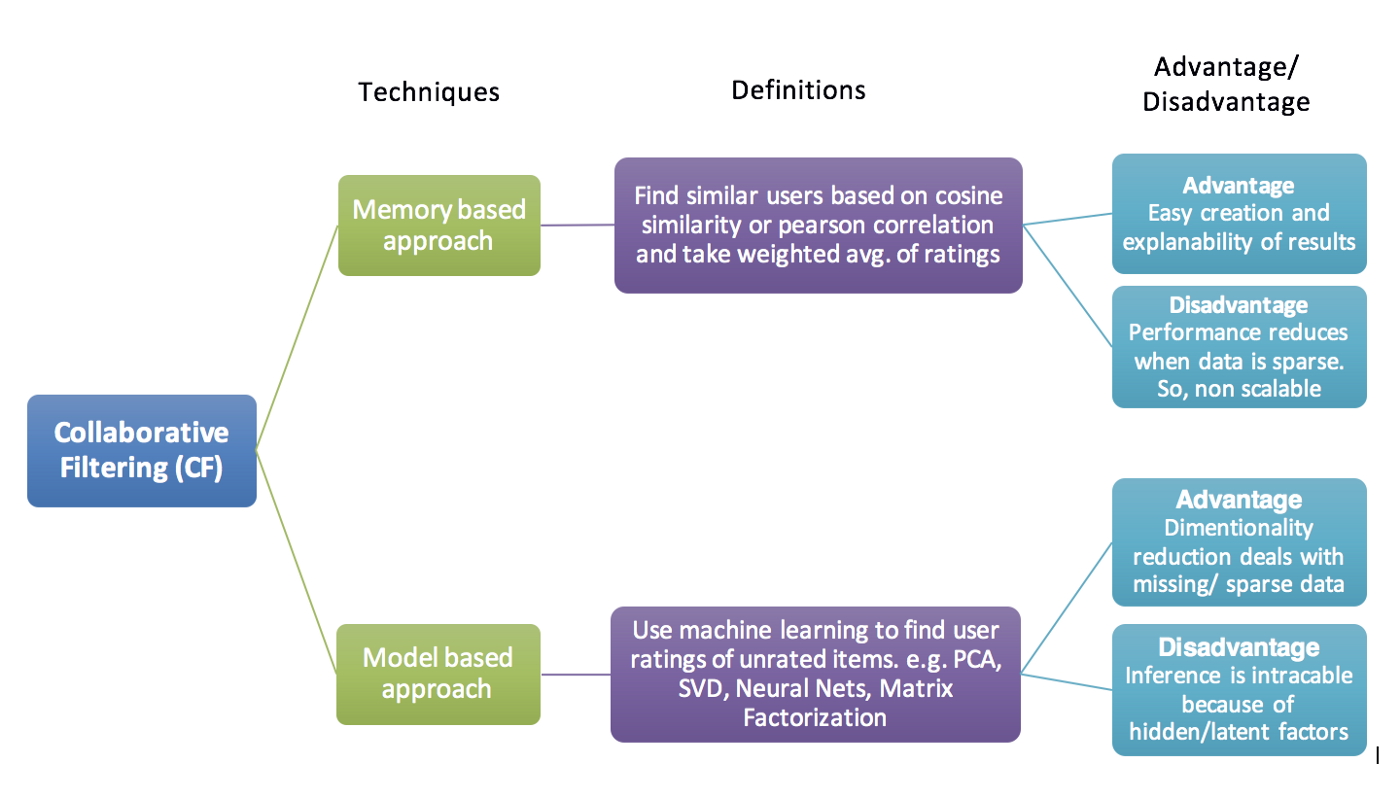

# Recommend with SVD - User Based

In [53]:
# κάνουμε pivot τον πίνακα
pivot = pd.pivot_table(df, index='UserId', columns=['Name'], values='Rating').fillna(0)
pivot.head(5)

Name,aegean,aer lingus,aeroloft,air astana,air baltic,air canada,air europa,air france,air mauritius,air transat,american airlines,nippon
UserId,,,,,,,,,,,,
1,1.0,1.0,5.0,1.0,5.0,1.0,1.0,5.0,5.0,2.0,5.0,4.0
2,1.0,1.0,4.0,5.0,1.0,1.0,1.0,5.0,5.0,5.0,1.0,1.0
3,1.0,1.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,4.0,5.0
4,4.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,5.0,4.0,1.0,5.0
5,5.0,1.0,1.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
pivot_mat = pivot.values
pivot_mat[:5]

array([[1., 1., 5., 1., 5., 1., 1., 5., 5., 2., 5., 4.],
       [1., 1., 4., 5., 1., 1., 1., 5., 5., 5., 1., 1.],
       [1., 1., 4., 1., 1., 1., 2., 1., 1., 4., 4., 5.],
       [4., 1., 1., 4., 1., 1., 1., 1., 5., 4., 1., 5.],
       [5., 1., 1., 5., 1., 2., 1., 1., 1., 1., 1., 1.]])

In [55]:
# Η στήλη user id είναι index, οπότε το αποθηκεύουμαι σε μια λίστα
user_id = list(pivot.index)
user_id[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [56]:
sparse_matrix = csr_matrix(pivot_mat)
sparse_matrix

<1998x12 sparse matrix of type '<class 'numpy.float64'>'
	with 11411 stored elements in Compressed Sparse Row format>

In [61]:
# αριθμοί factor για τον πίνακα
factor_n = 8

In [62]:
# παραγοντοποίηση πίνακα
U, sigma, V = svds(sparse_matrix, k = factor_n)

In [63]:
# διαστάσεις πίνακα
print(U.shape)
print(V.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(1998, 8)
(8, 12)
(8, 8)


In [64]:
pred_rating = np.dot(np.dot(U,sigma),V)
pred_rating[:5]

array([[ 1.08296677,  0.59651399,  5.01721592,  2.19935787,  0.53805853,
         1.06408941,  0.77101131,  5.5709149 ,  4.10593668,  2.10306462,
         5.10198711,  3.92071441],
       [ 0.82367215,  0.67356372,  4.87766572,  4.00845015,  0.5467979 ,
         1.122146  ,  0.65669909,  4.23617575,  5.71568379,  4.90072221,
         0.97750814,  1.04636089],
       [ 1.03508402,  1.45703535,  3.41785588,  1.25879557,  0.13153969,
         0.37805078,  2.2170684 ,  1.30380959,  1.28251929,  3.89730235,
         4.00148014,  5.0914604 ],
       [ 3.89997372, -0.2217736 ,  2.4896758 ,  4.02174023,  0.39922414,
         1.18402923,  0.35721434,  0.42190837,  4.33712743,  4.08918751,
         1.05549018,  4.84947879],
       [ 4.65113574,  0.79131026,  2.30313416,  3.15466395,  0.24177502,
         1.05478714,  0.54073303, -0.39584904,  2.89977087,  0.61783224,
         0.94591881,  1.21579395]])

Πρέπει να κανονικοποιήσω τον πίνακα μου πριν το recommendation λόγω μηδενικών τιμών.

In [65]:
# κανονικοποίηση
pred_rating_n = (pred_rating - pred_rating.min()) / (pred_rating.max() - pred_rating.min())

In [66]:
pred_rating_n[:5]

array([[0.26377782, 0.2056918 , 0.73355594, 0.39708308, 0.19871179,
        0.26152372, 0.22652805, 0.79967165, 0.62474253, 0.38558496,
        0.74367824, 0.60262564],
       [0.23281614, 0.2148921 , 0.71689263, 0.61310193, 0.19975533,
        0.2684561 , 0.21287834, 0.64029403, 0.81695811, 0.71964574,
        0.25118528, 0.25940681],
       [0.25806027, 0.30844434, 0.54258065, 0.28477306, 0.15017046,
        0.17960569, 0.39919785, 0.29014807, 0.28760585, 0.59983007,
        0.61226966, 0.74242127],
       [0.60014905, 0.10798227, 0.43174916, 0.61468886, 0.18213395,
        0.27584541, 0.17711767, 0.18484261, 0.6523484 , 0.62274256,
        0.26049691, 0.7135269 ],
       [0.68984329, 0.2289519 , 0.40947473, 0.51115361, 0.16333337,
        0.26041296, 0.19903114, 0.08719639, 0.48071751, 0.20823735,
        0.24741329, 0.27963835]])

In [67]:
# ανάθεση του νέου πίνακα στο dataframes
pred_df = pd.DataFrame(pred_rating_n, columns = pivot.columns, index=user_id).transpose()
pred_df.head(15)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
Name,,,,,,,,,,,,,,,,,,,,,
aegean,0.263778,0.232816,0.258060,0.600149,0.689843,0.405590,0.228705,0.252564,0.632800,0.736469,...,0.134313,0.134313,0.134313,0.134313,0.134313,0.134313,0.134313,0.134313,0.134313,0.134162
aer lingus,0.205692,0.214892,0.308444,0.107982,0.228952,0.344412,0.356048,0.466403,0.286859,0.292425,...,0.136299,0.136299,0.136299,0.136299,0.136299,0.136299,0.136299,0.136299,0.136299,0.138135
aeroloft,0.733556,0.716893,0.542581,0.431749,0.409475,0.652715,0.588200,0.641368,0.630894,0.677822,...,0.133231,0.133231,0.133231,0.133231,0.133231,0.133231,0.133231,0.133231,0.133231,0.131998
air astana,0.397083,0.613102,0.284773,0.614689,0.511154,0.491707,0.643735,0.449860,0.495781,0.723154,...,0.131878,0.131878,0.131878,0.131878,0.131878,0.131878,0.131878,0.131878,0.131878,0.129291
air baltic,0.198712,0.199755,0.150170,0.182134,0.163333,0.173491,0.177848,0.167313,0.172702,0.188635,...,0.135684,0.135684,0.135684,0.135684,0.135684,0.135684,0.135684,0.135684,0.135684,0.136904
air canada,0.261524,0.268456,0.179606,0.275845,0.260413,0.263041,0.318548,0.258271,0.271194,0.336132,...,0.135771,0.135771,0.135771,0.135771,0.135771,0.135771,0.135771,0.135771,0.135771,0.137078
air europa,0.226528,0.212878,0.399198,0.177118,0.199031,0.273432,0.278523,0.284511,0.286650,0.270900,...,0.135074,0.135074,0.135074,0.135074,0.135074,0.135074,0.135074,0.135074,0.135074,0.135685
air france,0.799672,0.640294,0.290148,0.184843,0.087196,0.389144,0.189174,0.276134,0.349982,0.280993,...,0.133978,0.133978,0.133978,0.133978,0.133978,0.133978,0.133978,0.133978,0.133978,0.133493
air mauritius,0.624743,0.816958,0.287606,0.652348,0.480718,0.508840,0.521664,0.358267,0.522189,0.739392,...,0.137212,0.137212,0.137212,0.137212,0.137212,0.137212,0.137212,0.137212,0.137212,0.139959


Τώρα,υπάρχει η παραγοντοποίηση SVD κάθε χρήστη για κάθε αεροπορική εταιρεία. Είναι ώρα για την τα recommendations.

In [74]:
def recommend_airlines(user_id ,pred_df, items_df, airlines_to_ignore=[], top_list=20, verbose=False):
      
        # αυτή η συνάρτηση βρήσκει τα πιο σχετικά στοιχεία
        sorted_user_predictions = pred_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Name'].isin(airlines_to_ignore)].sort_values(by='recStrength', ascending = False).head(top_list)
        print(recommendations_df)
        return recommendations_df


In [76]:
def recommender(user_id,pred_df,real_df,df_meta):
   
    #αυτή η συνάρτηση συγχωνεύει τον τίτλο με το αντίστοιχο αναγνωριστικό της αεροπορικής εταιρείας και βρίσκει τις κενές σειρές δηλαδή τα εστιατόρεια που δεν έχει επισκεφθεί ο χρήστης
    airlines_to_ignore = df[df['UserId'] == str(user_id)]['Name'].values
    recommend = recommend_airlines(user_id, pred_df,real_df, airlines_to_ignore)
    df_user= real_df.loc[real_df['UserId'] == user_id]
    new_df = df_user.merge(recommend, how = 'outer', left_on = 'Name', right_on = 'Name')
    rec_df = new_df.loc[new_df['Rating'].isnull()==True]
    df_rec_t = rec_df.loc[:, ['Name', 'recStrength']]
    df_last = pd.merge(df_rec_t,df_meta[['AirlineId','Name']],on=['Name'], how='left')
    df_last = df_last.drop_duplicates(subset=["Name", "AirlineId"], keep='first')
    df_last = df_last.reset_index(drop=True) 
    return df_last

In [71]:
airlines = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Airlines Reviews/airlines.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Airlines Reviews/ratings.csv')
df_meta = airlines.merge(ratings, how="left", on="AirlineId")
df_meta = df_meta.astype({"UserId": str, "AirlineId": str})
df_meta.head()

,AirlineId,Name,UserId,Review,Rating
0,1,aegean,1,Forgot my baggage,1
1,1,aegean,2,Late or cancelled,1
2,1,aegean,3,Worst experience ever! AVOID AEGEAN!,1
3,1,aegean,4,A great airline,4
4,1,aegean,5,"Accommodating, Lovely Airline",5


In [72]:
df = df.astype({"UserId": str})
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage,12,1200
1,105,nippon,like going back in time. seats.,5,neutral,2,like going back in time seats,12,1300
2,112,nippon,okay,3,approval,1,okay,12,1300
3,111,nippon,nice airline but seats are not so comfortable,3,disapproval,1,nice airline but seats are not so comfortable,12,1300
4,110,nippon,i am in love with this airline,5,love,2,i am in love with this airline,12,1300
...,...,...,...,...,...,...,...,...,...
11406,1422,american airlines,worst airline ever,1,anger,0,worst airline ever,1,1998
11407,1421,american airlines,disappointed!,1,disappointment,0,disappointed,1,1998
11408,1420,american airlines,worst staff !!!,1,anger,0,worst staff,1,1998
11409,1419,american airlines,worst travel experience ever,1,fear,0,worst travel experience ever,1,1998


In [80]:
recommender(1245,pred_df,df,df_meta)

             Name  recStrength
2      air canada     0.162117
3        aeroloft     0.144438
4      air baltic     0.143879
5      air astana     0.142822
6     air transat     0.140714
7      air france     0.136341
8          aegean     0.135921
9      air europa     0.129439
10     aer lingus     0.119798
11  air mauritius     0.109823


,Name,recStrength,AirlineId
0,air canada,0.162117,6
1,aeroloft,0.144438,2
2,air baltic,0.143879,5
3,air astana,0.142822,4
4,air transat,0.140714,10
5,air france,0.136341,8
6,aegean,0.135921,1
7,air europa,0.129439,7
8,aer lingus,0.119798,3
9,air mauritius,0.109823,9


# Recommend with Cosine Similarity - User Based

In [81]:
user_sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
user_recommender = pw.cosine_similarity(user_sparse_pivot)

In [82]:
pred_rating_n_cos = (user_recommender - user_recommender.mean())/ (user_recommender.max() - user_recommender.min())

In [83]:
user_recommender_df = pd.DataFrame(pred_rating_n_cos, columns=pivot.index.values,index = pivot.index.values)

Στην μέθοδο αυτή, έχουμε ένα user-user matrix, που δείχνει τις σχέσεις τους και με βάζει αυτόν θα γίνουν οι συστάσεις.

In [84]:
user_recommender_df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
1,0.560554,0.299384,0.336748,0.203250,-0.019792,0.350947,0.109359,0.378380,0.314518,0.193135,...,-0.078856,-0.078856,-0.078856,-0.078856,-0.078856,-0.078856,-0.078856,-0.078856,-0.078856,-0.078856
2,0.299384,0.560554,0.181619,0.316727,0.167409,0.301050,0.230168,0.209820,0.279435,0.333150,...,-0.422556,-0.422556,-0.422556,-0.422556,-0.422556,-0.422556,-0.422556,-0.422556,-0.422556,-0.422556
3,0.336748,0.181619,0.560554,0.262390,-0.000110,0.232248,0.160822,0.418329,0.272713,0.092623,...,-0.048399,-0.048399,-0.048399,-0.048399,-0.048399,-0.048399,-0.048399,-0.048399,-0.048399,-0.048399


In [87]:
def recommend2(user_recommender_df,user_id,df_meta):
    #Αυτή η συνάρτηση βρίσκει πρώτα τους 2 πιο όμοιους χρήστες και μετά 
    #παίρνει τον μέσο όρο των αξιολογήσεών τους στις αεροπορικές εταιρείες και τα ταξινομεί σύμφωνα με τις μέσες τιμές
    user_cosine_df = pd.DataFrame(user_recommender_df[user_id].sort_values(ascending=False))
    user_cosine_df.reset_index(level=0, inplace=True)
    user_cosine_df.columns = ['Name','cosine_sim']
    
    # για 2 όμοιους χρήστες
    similar_user = list(user_cosine_df['Name'][1:3].values)
    similar_user_df = pivot.T[[user_id] + similar_user]
    similar_user_df['mean'] = similar_user_df[similar_user].mean(numeric_only=True,axis=1)
    similar_user_df.sort_values('mean', ascending=False,inplace = True)
    
    # πέρνουμε 10 αεροπορικές εταιρείες από παρόμοιους χρήστες και γίνεται η συγχώνευσή τους
    restaurant_top10 = similar_user_df[similar_user_df[user_id]==0].head(10)
    df_last1 = pd.merge(restaurant_top10,df_meta[['AirlineId','Name']],on=['Name'], how='left')
    df_last1 = df_last1.drop_duplicates(subset=["Name", "AirlineId"], keep='first')
    df_last1 = df_last1.reset_index(drop=True) 
    return df_last1

In [88]:
recommend2(user_recommender_df,1250,df_meta)

,Name,1250,1238,1281,mean,AirlineId
0,aegean,0.0,0.0,0.0,0.0,1
1,aer lingus,0.0,0.0,0.0,0.0,3
2,aeroloft,0.0,0.0,0.0,0.0,2
3,air astana,0.0,0.0,0.0,0.0,4
4,air baltic,0.0,0.0,0.0,0.0,5
5,air canada,0.0,0.0,0.0,0.0,6
6,air europa,0.0,0.0,0.0,0.0,7
7,air france,0.0,0.0,0.0,0.0,8
8,air mauritius,0.0,0.0,0.0,0.0,9
9,air transat,0.0,0.0,0.0,0.0,10


# Recommendations from Keywords

## Recommending based on cosine similarity of reviews

In [89]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import math
from collections import Counter
import operator

In [90]:
stop = set(stopwords.words("english")) #σετάρουμε τα stopwords

In [91]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage,12,1200
1,105,nippon,like going back in time. seats.,5,neutral,2,like going back in time seats,12,1300
2,112,nippon,okay,3,approval,1,okay,12,1300
3,111,nippon,nice airline but seats are not so comfortable,3,disapproval,1,nice airline but seats are not so comfortable,12,1300
4,110,nippon,i am in love with this airline,5,love,2,i am in love with this airline,12,1300
...,...,...,...,...,...,...,...,...,...
11406,1422,american airlines,worst airline ever,1,anger,0,worst airline ever,1,1998
11407,1421,american airlines,disappointed!,1,disappointment,0,disappointed,1,1998
11408,1420,american airlines,worst staff !!!,1,anger,0,worst staff,1,1998
11409,1419,american airlines,worst travel experience ever,1,fear,0,worst travel experience ever,1,1998


In [92]:
df['word_without_stop'] = df['Review_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [93]:
def cosine_similarity_of(text1, text2):
        
        # διαβάζουμε τις λέξεις
        first = re.compile(r"[\w']+").findall(text1)
        second = re.compile(r"[\w']+").findall(text2)

        # δημιουργεία λεξιλογίου
        vector1 = Counter(first)
        vector2 = Counter(second)

        # αλλάζοντας διανύσματα σε σύνολα για να βρούμε κοινές λέξεις με τομή
        common = set(vector1.keys()).intersection(set(vector2.keys()))

        dot_product = 0.0

        for i in common:
          
            dot_product += vector1[i] * vector2[i]

        squared_sum_vector1 = 0.0
        squared_sum_vector2 = 0.0

        # άθροισμα των μετρήσεων λέξεων για κάθε διάνυσμα
        for i in vector1.keys():
            squared_sum_vector1 += vector1[i]**2

        for i in vector2.keys():
            squared_sum_vector2 += vector2[i]**2

        # υπολογισμός του μεγέθους του διανύσματος με άθροισμα τετραγώνων
        magnitude = math.sqrt(squared_sum_vector1) * math.sqrt(squared_sum_vector2)

        if not magnitude:
            return 0.0
        else:
            return float(dot_product) / magnitude

In [94]:
text1 = df['word_without_stop'][1] 
text2 = df['word_without_stop'][2] 
cosine_similarity_of(text1, text2)

0.0

In [95]:
def get_recommendations(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            score_dict[index] = cosine_similarity_of(row['word_without_stop'], keywords)

        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similarities
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('UserId', 'Name','word_without_stop', 'score'))

        # κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
            result = result.append({'UserId': df.iloc[i[0]]['UserId'], 
                                        'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break

        return result



In [96]:
keywords = "happy air hostes"

In [97]:
top_10= get_recommendations(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,UserId,Name,word_without_stop,score
0,564,air transat,happy air transat,0.666667
1,115,american airlines,air,0.577350
2,499,air canada,air canada terrible air line,0.436436
3,505,air europa,love air mit air europe,0.436436
4,658,air mauritius,air mauritius like air hideous,0.436436
5,24,air astana,air astana,0.408248


## Rating Effect Adding

θα προσθέσω ένα weight του rating στη λειτουργία του συστήματος. Για να γίνει αυτό, θα καθορίσω πόσο θέλω να επηρεάστουν τα αποτελέσματα. Θα χρησιμοποιήσω απλή μαθηματική εξίσωση, weigth = (2*Q/5)*rating - Q. 

Το Q καθορίζει πόσο θα επηρεάσει. Για Q=10 και rating = 5, το cosine similarity αυξάνεται κατά 10%.

In [98]:
def rating_weight(rating,Q):
    #υπολογισμός του βάρους του rating
    w = (2*Q/5)*rating - Q
    return w

In [99]:
def calculate_final_score(cos_sim, w):
        # προσθέτοντας την επίδραση του βάρους στο cosine similarity
        effect = (cos_sim / 100) * w
        return cos_sim + effect

In [100]:
def get_recommendations_rat(df,keywords):
        score_dict = {}

        for index, row in df.iterrows():
            cs_score = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            
            # Επιλέγουμε Q=10
            rating_effect = rating_weight(rating,10)

            last_score = calculate_final_score(cs_score, rating_effect)

            score_dict[index] = last_score
            
        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similaritiess
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))

         #  κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
              

            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break
                
        return result



In [101]:
keywords = "best flight ever"

In [102]:
top_10= get_recommendations_rat(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,air astana,best flight ever,5,1.100000
1,nippon,best flight ever,5,1.100000
2,air mauritius,best flight ever travelled,5,0.952628
3,aegean,best airline ever flight,5,0.952628
4,air europa,best flight,5,0.898146
5,american airlines,one best international flight ever,5,0.852056
6,aeroloft,best routine flight,5,0.733333


## Number of Ratings Effect

Είναι δύσκολο να πούμε ότι μια αεροπορική εταιρεία που έχει μέση βαθμολογία 5 με μόνο 8 σχόλια είναι καλύτερο από το εστιατόριο που βαθμολογήθηκε με 4 με 2000 κριτικές. Περισσότερες κριτικές για το προϊόν σημαίνει μεγαλύτερη αξιοπιστία.

Έτσι, θα προσθέσω πολλαπλασιαστή στη συνάρτηση βαθμολόγησης που δίνει μικρότερο αποτέλεσμα εάν η βαθμολογία είναι μικρότερη από το όριο.

Θα χρησιμοποιήσουμε ως multipier to e^(({-t)*0.68)/ratingsnumber)

In [103]:
math.exp(-0.68) # όταν το t ισούται με τον αριθμό των ratings.

0.5066169923655895

In [104]:
def get_rating_weight_with_threshold(rating, count, threshold, Q):
            # υπολογισμός του βάρους του rating
            w = (2*Q/5)*rating - Q
            # multiplier
            M = math.exp((-threshold*0.68)/count)

            return w * M

In [105]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count,word_without_stop
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage,12,1200,forgot baggage
1,105,nippon,like going back in time. seats.,5,neutral,2,like going back in time seats,12,1300,like going back time seats
2,112,nippon,okay,3,approval,1,okay,12,1300,okay
3,111,nippon,nice airline but seats are not so comfortable,3,disapproval,1,nice airline but seats are not so comfortable,12,1300,nice airline seats comfortable
4,110,nippon,i am in love with this airline,5,love,2,i am in love with this airline,12,1300,love airline
...,...,...,...,...,...,...,...,...,...,...
11406,1422,american airlines,worst airline ever,1,anger,0,worst airline ever,1,1998,worst airline ever
11407,1421,american airlines,disappointed!,1,disappointment,0,disappointed,1,1998,disappointed
11408,1420,american airlines,worst staff !!!,1,anger,0,worst staff,1,1998,worst staff
11409,1419,american airlines,worst travel experience ever,1,fear,0,worst travel experience ever,1,1998,worst travel experience ever


In [106]:
def get_recommendations_rat_count(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            cs = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            rating_count = row['Restaurant_Count']
            threshold = 110
           
            rating_contribution = get_rating_weight_with_threshold(rating,rating_count,threshold,10)

            last_score = calculate_final_score(cs, rating_contribution)

            score_dict[index] = last_score
            
     
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0


        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))
        
        for i in sorted_scores:
            
            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break
                
        return result

In [107]:
keywords = "best flight ever"
top_10 = get_recommendations_rat_count(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,nippon,best flight ever,5,1.094409
1,air astana,best flight ever,5,1.088334
2,aegean,best airline ever flight,5,0.947395
3,air mauritius,best flight ever travelled,5,0.943851
4,air europa,best flight,5,0.892779
5,american airlines,one best international flight ever,5,0.849210


## Positive Review Effect

Τώρα, θέλω να δώσω μεγαλύτερη βαρύτητα στη βαθμολογία μου εάν η κριτική είναι θετική. Για να γίνει αυτό, θα δημιουργήσω νέες στήλες που είναι True όταν η βαθμολογία είναι ίση ή μεγαλύτερη από 3.

Θέτουμε newrating = rating + (7 - rating)/2 = (rating+7)/2

In [108]:
df['positive'] = df['Rating'].apply(lambda x: True if x>=3 else False)

In [109]:
def get_recommendations_rat_count_pos(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            cs = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            rating_count = row['Restaurant_Count']
            
            if row['positive']==True:
                pos_rat = (7+rating)/2
            else:
                pos_rat = rating/2
                
            threshold=110
            
            rating_contribution =get_rating_weight_with_threshold(pos_rat,rating_count,threshold,10)

            last_score = calculate_final_score(cs, rating_contribution)
   
            score_dict[index] = last_score

        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))

        for i in sorted_scores:
            
            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            
            counter += 1

            if counter>15:
                break
                
        return result

In [110]:
keywords = "safest flight"
top_10= get_recommendations_rat_count_pos(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,air transat,flight,5,0.799868
1,aeroloft,flight,5,0.798933
2,air france,flight,5,0.797762
3,aer lingus,flight,1,0.655050
4,aegean,flight,1,0.653957
5,american airlines,great flight,5,0.567428
6,nippon,alternative flight,5,0.566086


In [111]:
df.to_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Airlines Reviews/airlines_for_keywords_recommendation.csv', index = False)

In [112]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count,word_without_stop,positive
0,1,aegean,forgot my baggage,1,neutral,0,forgot my baggage,12,1200,forgot baggage,False
1,105,nippon,like going back in time. seats.,5,neutral,2,like going back in time seats,12,1300,like going back time seats,True
2,112,nippon,okay,3,approval,1,okay,12,1300,okay,True
3,111,nippon,nice airline but seats are not so comfortable,3,disapproval,1,nice airline but seats are not so comfortable,12,1300,nice airline seats comfortable,True
4,110,nippon,i am in love with this airline,5,love,2,i am in love with this airline,12,1300,love airline,True
...,...,...,...,...,...,...,...,...,...,...,...
11406,1422,american airlines,worst airline ever,1,anger,0,worst airline ever,1,1998,worst airline ever,False
11407,1421,american airlines,disappointed!,1,disappointment,0,disappointed,1,1998,disappointed,False
11408,1420,american airlines,worst staff !!!,1,anger,0,worst staff,1,1998,worst staff,False
11409,1419,american airlines,worst travel experience ever,1,fear,0,worst travel experience ever,1,1998,worst travel experience ever,False
